# B-Splines
This notebook introduces how to construct B-Splines and implement them in parameter estimation Markov Chain Monte-Carlo algorithms. 

[this section is from Wiki](https://en.wikipedia.org/wiki/B-spline)

A Basis Spline (B-Spline) of order $k$ is a piecewise polynomial funciton of degree $d = k-1$ of a variable $x$. The $x$ values where the pieces of the polynomials meet are called knots and are denoted as $t_0, t_1, t_2, ..., t_n$. The 1st and 2nd derivatives of the spline are continuous at these knot locations. A collection of Basis Splines is referred to as a basis, wherein the individual Basis Splines are spaced along the domain $x$ and linear combinations of the Basis Splines evaluated at $x$ will produce some desired curve $y$. For example, a linear combination of 3 B-Splines looks like:

$$
y = \alpha_1 B_1(x) + \alpha_2 B_2(x) + \alpha_3 B_3(x)
$$

or in matrix notation, where each B-Spline is evaluated at locations $x_1, x_2, ..., x_m$:

$$
y = \left(
\begin{array}{ll}
      B_1(x_1) & B_2(x_1) & B_3(x_1) \\
      B_1(x_2) & B_2(x_2) & B_3(x_2) \\
      \vdots & \vdots & \vdots \\
      B_1(x_m) & B_2(x_m) & B_3(x_m) \\
\end{array}
\right) 

\left(
      \begin{array}{ll}
      \alpha_1 \\
      \alpha_2 \\
      \alpha_3 \\
\end{array}
\right).
$$

This matrix is known as the **design matrix**.

For a given domain and desired number $n$ of $k$ order basis splines, the required number of knots within the domain (interior_knots) is $N_{interior} = n - k + 2$. For example, for $n=5$ basis splines of order $k = 4$, the number of interior knots is $N_{interior} = 3$. 

In order to construct a basis of B-Splines, we use the Cox-De Boor recursion relation:

$$
B_{n, d = 1}(x) = \left\{
\begin{array}{ll}
      1 & \text{if } t_n \leq x <t_{n+1}  \\
      0 & \text{otherwise} \\
\end{array} 
\right.   
$$

$$
B_{n,d}(x) = \frac{x-t_n}{t_{n+d} - t_n} B_{n,d-1}(x) + \frac{t_{n+d+1} - x}{t_{n+d + 1} - t_{n+1}} B_{n+1,d-1}(x)
$$

## Problem 1:
Construct a basis of 10 B-Splines of order $k =4$ along domain $x = [0,10]$. Make a plot of your resulting basis functions. The below code will walk you through each step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import jax.numpy as jnp

ModuleNotFoundError: No module named 'numpy'

First, we need to construct our knot vector. In order to actually compute our basis, our knot vector needs to extend past our domain, since the two b-splines on the edges of the domain will necessarily extend beyond the allowed values of $x$. The total number of knots we need is then $N_{interior} + 2d$. We will also choose to equally space our knots apart, which allows us to make use of `np.linspace()`. Make sure the knots outside of the domain are also equally spaced. 

I've constructed an array with the interior knots and calculated the spacing between each knot. Your job is to figure out how to add the knots outside of the domain $x=[0,10]$. 

*HINT: use `np.linspace()`*

In [ ]:
xmin = 0
xmax = 10
n = 10 # number of b-splines
k = 4 # order of the b-splines (degree 3 polynomials)
d = k-1
interior_knots = np.linspace(0, 1, n - k + 2)
dx = interior_knots[1] - interior_knots[0]
#Ninterior = n-k+2
knots = np.linspace(xmin - dx*(xmax-xmin)*(k-1), xmax + dx*(xmax-xmin)*(k-1), (n-k+2)+2*(k-1))
t = knots

To make sure we constructed our knot vector correctly, it's good to check that it contains exactly our two end points. Come up with a way to visualize your knots to check that two of them are equal to `xmin` and `xmax` and they are all equally spaced:

Knot Min: -4.285714285714285
Knot Max: 14.285714285714285
xmin (0) != Knot Min (-4.285714285714285)
xmax (10) != Knot Max (14.285714285714285)


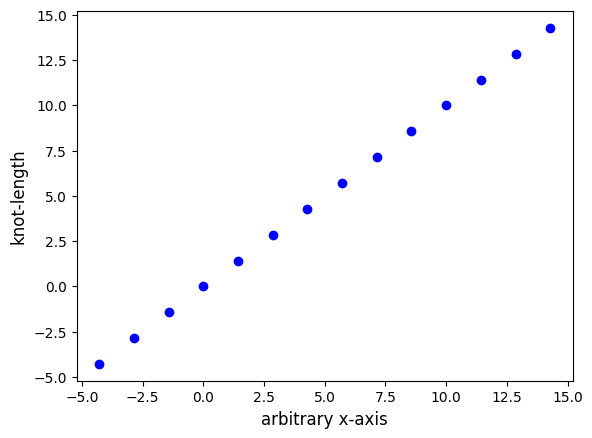

In [ ]:
plt.plot(t,t, 'bo')
plt.xlabel('arbitrary x-axis', fontsize=12)
plt.ylabel('knot-length', fontsize=12)
plt.show

l = len(t)
min = t[0]
max = t[l-1]
print(f"Knot Min: {min}")
print(f"Knot Max: {max}")

if xmin == min:
    print(f"xmin ({xmin}) == Knot Min ({min})")
else:
    print(f"xmin ({xmin}) != Knot Min ({min})")

#Likewise

if xmax == max:
    print(f"xmax ({xmax}) == Knot Max ({max})")
else:
    print(f"xmax ({xmax}) != Knot Max ({max})")

Next, make a function for the $k=1$ case:

In [ ]:
def b_1(x, upper, lower):
    """Caculates the k=1 case for a k-order Basis Spline

    Args:
        x (array-like): x value(s) to evaluate the function at
        upper (float): upper bound of domain
        lower (float): lower bound of domain
    """
    v = np.zeros_like(x)
    v[(x >= lower) & (x < upper)] = 1
    return v

In [ ]:
def basis(x, k, i):
    """_summary_

    Args:
        x (array-like): x value(s) to evaluate the function at
        k (int): order of the B-Spline
        i (int): B-Spline index (i = 1 to the total number of B-Splines in the basis)
    """
    if k == 0:
        return b_1(x, t[i+1], t[i])
    else:
        return ((x - t[i])/(t[i+k] - t[i])*basis(x, k-1, i))+((t[i+k+1]-x)/(t[i+k+1] -t[i+1])*basis(x, k-1, i+1))



**If you've constructed the above functions correctly, you should be able to run the next 3 cells without making any changes.**

Here is the function that will construct our design matrix:

In [ ]:
def bases(x, n):
    return np.array([np.array(basis(x, d, i)) for i in range(n)])

Now we can use these functions to construct our design matrix. We'll need to define the points along our domain where we will evaluate our B-Splines at. If you've defined your functions correctly above, you should get a design matrix with shape $(n\times m)$, where $n = $ number of Basis-Splines, $m = $ number of data points. In this case, $(10\times 1000)$

In [ ]:
x = np.linspace(xmin,xmax,1000)
design_matrix = bases(x, n)
# print('desing matrix shape: ', design_matrix.shape)
print(design_matrix)

[[0.16666667 0.16318765 0.1597574  ... 0.         0.         0.        ]
 [0.66666667 0.66661774 0.66647165 ... 0.         0.         0.        ]
 [0.16666667 0.17019455 0.17377049 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.17377049 0.17019455 0.16666667]
 [0.         0.         0.         ... 0.66647165 0.66661774 0.66666667]
 [0.         0.         0.         ... 0.1597574  0.16318765 0.16666667]]


Let's plot our basis to see what it looks like:

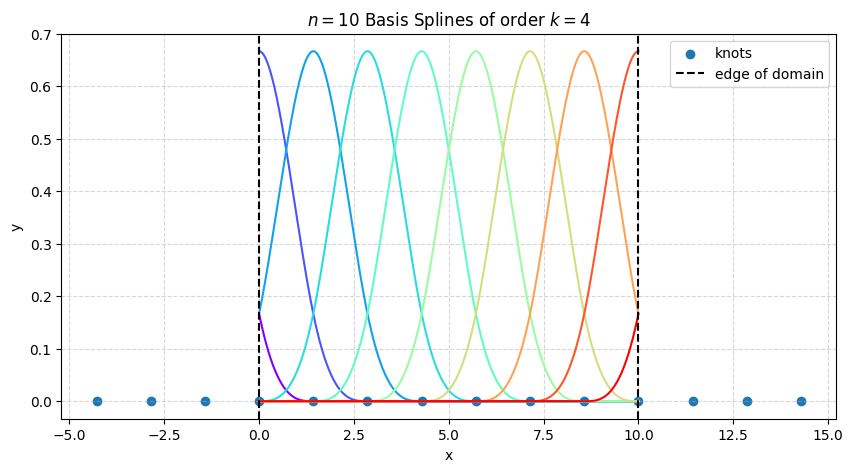

In [ ]:
import matplotlib
cm = plt.cm.rainbow(np.linspace(0,1,n))
colors = []
for i in range(len(cm)):
    colors.append(matplotlib.colors.rgb2hex(cm[i]))

plt.figure(figsize = (10,5))
for i in range(design_matrix.shape[0]):
    plt.plot(x, design_matrix[i], color = colors[i])
plt.scatter(knots, np.zeros_like(knots), label = 'knots')
plt.axvline(xmin, color = 'k', ls = '--', label = 'edge of domain')
plt.axvline(xmax, color = 'k', ls = '--')
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('x')
plt.ylabel('y')
plt.title(rf'$n={n}$ Basis Splines of order $k = {k}$')
plt.legend()
plt.show()

# Spline Regression

Now that we have constructed our spline basis, we can use it to fit some data. 

In standard polynomial regression, we use least squares minimization to determine the coefficients of our best-fit polynomial. For example, given a set of data $\{(x_1,y_1), ..., (x_m, y_m)\}$ and quadratic model $\mu_i = \alpha_0 + \alpha_1 x_i+ \alpha_2 x_i^2$, we minimize the least squares equation:

$$
S = \sum^m_{i=1}(y_i - \mu_i)^2 = \sum^m_{i=1}(y_i - \alpha_0 - \alpha_1 x - \alpha_2 x^2)^2.
$$

In matrix notation, this looks like 
$$
S = ||\vec{y}-\vec{\mu}||^2 = ||\vec{y}-B\vec{\alpha}||^2.
$$
where
$$
B = \left(
\begin{array}{ll}
      1 & x_1 & x_1^2 \\
      1 & x_2 & x_2^2 \\
      \vdots & \vdots & \vdots \\
      1 & x_m & x_m^2 \\
\end{array}
\right),\;
\vec{\alpha} = 
\left(
      \begin{array}{ll}
      \alpha_0 \\
      \alpha_1 \\
      \alpha_2 \\
\end{array}
\right).
$$

The solution, $\vec{\alpha}$, that minimizes $S$ is given by

$$
\vec{\alpha} = (B^TB)^{-1}B^T\vec{y}.
$$

Note that the elements of $B$ here are just some functions of $x$, i.e. $x^0, x^1, x^2$. The Basis-Spline design matrix also just has elements that are some functions of $x$, so the solution above, $\vec{\alpha}$, is also a solution for the basis-spline case! Therefore, once we have our design matrix, we can use the formula for $\vec{\alpha}$ to determine the shape of our B-Spline best-fit. Lets try out an example below.

## Problem 2:

First, we'll need to create a function that performs the matrix operations to compute $\vec{\alpha}$. Note that depending on how you construct your design matrix, it could have shape $(n \times m)$ or $(m \times n)$. The equation for $\vec{\alpha}$ above assumes $B$ has shape $(m \times n)$, so you may have to transpose your design matrix in order to correctly compute $\vec{\alpha}$. 

*HINT: use the `numpy` functions `np.transpose()`, `np.linalg.inv()`, `np.matmul` and `np.einsum()`. You can find out the details of each function in the [numpy documentation](https://numpy.org/doc/stable/reference/routines.linalg.html)*

In [ ]:
def interp(x, y, n):
    """computes the coefficients alpha for a Basis-Spline fit to some data x. 

    Args:
        x (array-like): x-values of data
        y (array-like): y-values of data
        n (int): number of Basis-Splines

    Returns:
        ys (array-like): the y-values of the interpolated curve
        alpha (array-like): the basis spline coefficients
        design_matrix (array_like): the design matrix evaluated at x
    """
    B = bases(x,n)
    B = np.transpose(B)
    design_matrix = B

    alpha = np.linalg.inv(np.transpose(B).dot(B)).dot(np.transpose(B).dot(y))
    #Interpolate new x vector and call get data for y vector

    #Here I thought I would interpolate to some arbitrarily large size array with the new_x and return the new intopolated array ys, but I realized that the assignment was not made that way, and in fact the interpolation happens manually later in the code
    # new_x = np.linspace(xmin,xmax,1000)

    #Note, I would also provide parameters n which would give the metric for the interpolation, then I would return x and y. It would look something like this:

    ys = y
    """
        Args:
        x (array-like): x-values of data
        y (array-like): y-values of data
        n (int): number of Basis-Splines
        a (int): metric for interpoation
    Returns:
        ys (array-like): the y-values of the interpolated curve
        xs (array-like): the x-values of the interpolated curve
        alpha (array-like): the basis spline coefficients
        design_matrix (array_like): the design matrix evaluated at x

    
    """

    return ys, alpha, design_matrix


**If you correctly constructed the function `interp()` above, then you should be able to run the remaining cells in this problem witout issues**

We'll need some fake data to test this out on. I've constructed some below:

In [ ]:
def get_data(
    N,
    err = 0.03
):
    x = np.linspace(xmin,xmax,N)
    y = np.cos(x) + np.random.normal(0,err*(xmax-xmin), N)
    true_y = np.cos(x)
    print(x.shape)
    print(true_y.shape)
    
    return x, y, true_y

In [ ]:
x = get_data(100)
y = interp([2,3,1,2],[4,2,4,5], 2)

(100,)
(100,)


NameError: name 'ys' is not defined

(30,)
(30,)


Text(0, 0.5, 'y')

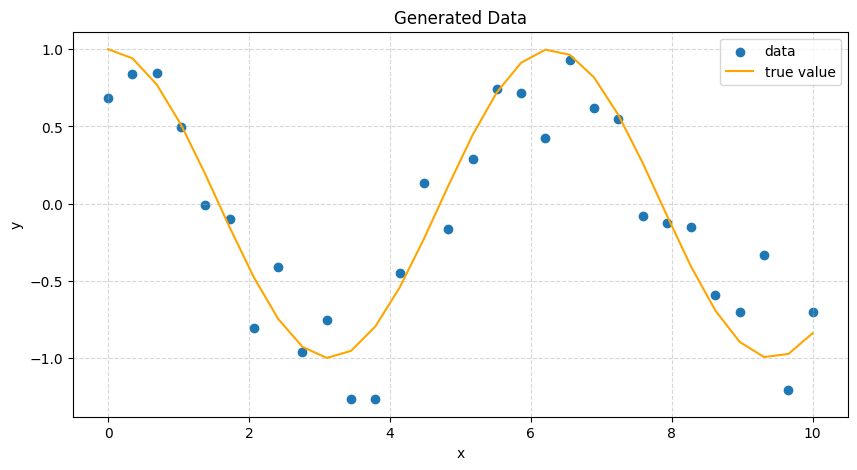

In [ ]:
data = get_data(30)
plt.figure(figsize = (10,5))
plt.scatter(data[0], data[1], label = 'data')
plt.plot(data[0], data[2], color = 'orange',label = 'true value')
plt.legend()
plt.title('Generated Data')
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('x')
plt.ylabel('y')

Now to compute our curve of best fit. 

In [ ]:
ys, alpha, design_matrix = interp(data[0], data[1], n)

print(f"ys shape: {ys.shape}")
print(f"alpha shape: {alpha.shape}")
print(f"Design Matrix shape: {design_matrix.shape}")
# print(ys)
print(alpha)
# print(design_matrix)

ys shape: (30,)
alpha shape: (10,)
Design Matrix shape: (30, 10)


Text(0, 0.5, 'y')

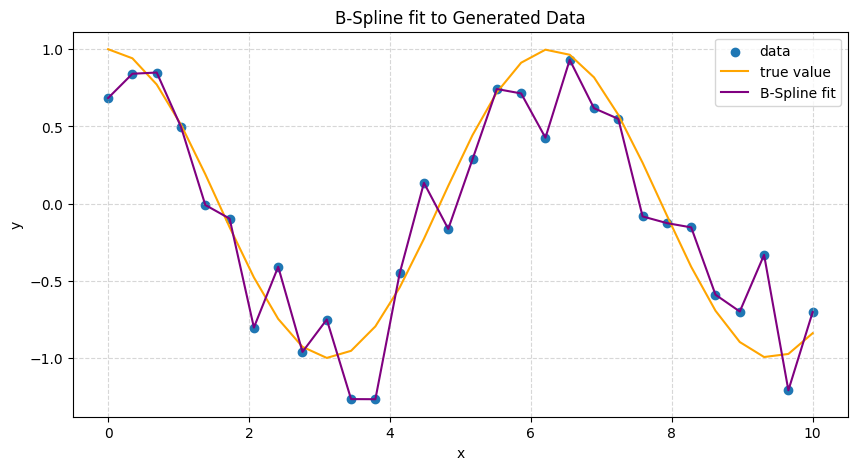

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(data[0], data[1], label = 'data')
plt.plot(data[0], data[2], color = 'orange',label = 'true value')
plt.plot(data[0], ys, color = 'purple',label = 'B-Spline fit')
plt.legend()
plt.title('B-Spline fit to Generated Data')
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('x')
plt.ylabel('y')

We've successfully created our first B-Spline!

To plot a finer interoplation of our spline, we can construct a new design matrix $B$ with more x-values and use our $\alpha$ values we calculated above:

In [ ]:
x = np.linspace(0,10,100)
dmat = bases(x,n)
ys = np.einsum('ji,j->i', dmat, alpha)

Text(0, 0.5, 'y')

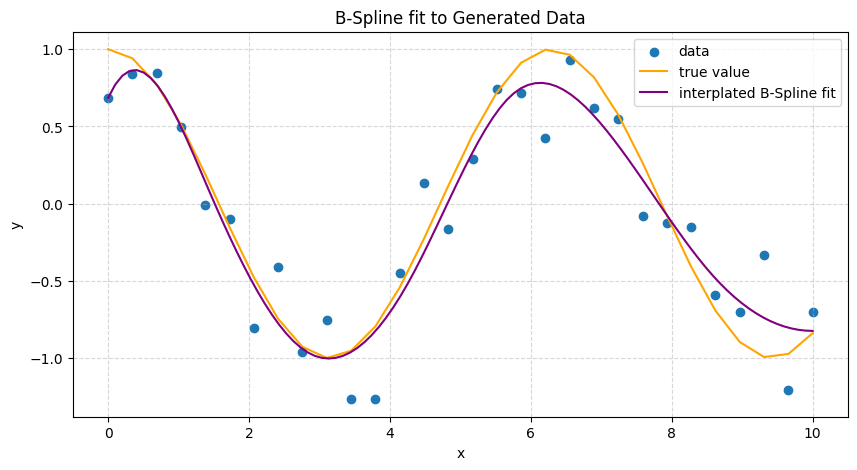

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(data[0], data[1], label = 'data')
plt.plot(data[0], data[2], color = 'orange',label = 'true value')
plt.plot(x, ys, color = 'purple',label = 'interplated B-Spline fit')
plt.legend()
plt.title('B-Spline fit to Generated Data')
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('x')
plt.ylabel('y')

# Spline Regression with MCMC

This is great, but we aren't Frequentists, after all. Let's construct an sampler with `numpyro` to estimate $\vec{\alpha}$ for us like true Bayesians.

First, a little bit of math:

Suppose we have some measurement $y(x)$ that represents some true value $\hat{y}(x)$ plus some random noise/error $n$, 

$$
y(x) = \hat{y}(x) + n
$$.

If the random noise is Gaussian (it doesn't have to be, but it often is),

$$
n \sim \mathcal{N}(0,\sigma)
$$.

then if you were to make measurements of $y$ at the same value of $x$ many times and plot a histogram of your results, the histogram would look like a normal distribution with a mean centered on on the true value $\hat{y}(x)$ and standard deviation $\sigma$:

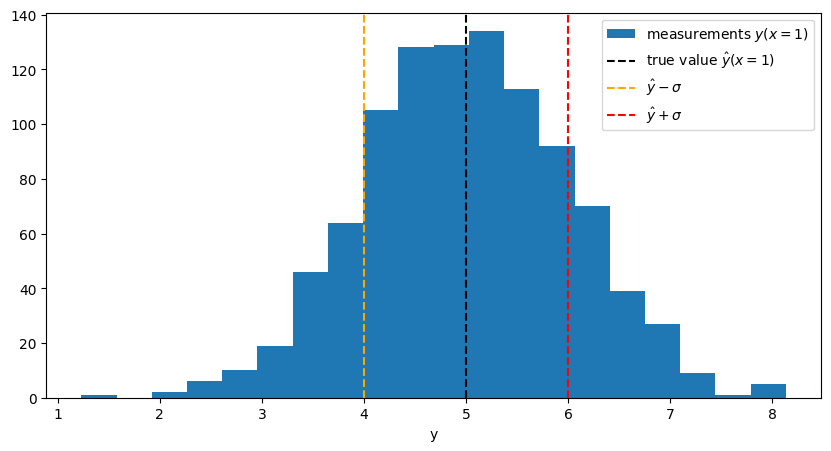

In [ ]:
N = 1000
theta = 5
x = np.ones(N)
sigma = 1
noise = np.random.normal(0, sigma, N)
y = theta*x + noise

plt.figure(figsize = (10,5))
plt.hist(y, bins = 20, label = r'measurements $y(x=1)$')
plt.axvline(theta*x[0], ls = '--', color = 'k', label = r'true value $\hat{y}(x=1)$')
plt.axvline(theta*x[0]-sigma, ls = '--', color = 'orange', label = r'$\hat{y}-\sigma$')
plt.axvline(theta*x[0]+sigma, ls = '--', color = 'r', label = r'$\hat{y}+\sigma$')
plt.xlabel('y')
plt.legend()
plt.show()

The likelihood $p(y_i|\theta, x_i)$ of this data point, i.e. the probability that we observe $y$ assuming some model $\hat{y}(\theta, x)$ is true, is therefore the above normal distribution (centered on $\hat{y}(\theta,x)$ with stardard deviation $\sigma$):

$$
p(y_i|\theta, x_i) = \mathcal{N}(y_i|\mu=\hat{y}, \sigma=\sigma)
$$

where $\theta$ are the parameters that describe the true distribution $\hat{y}$. 


Now if we to make $m$ measurements at different $x$ locations and assuming each measurement is independent of all other measurements, the likelihood of the resulting dataset is just the product on the individual likelihoods:

$$
P(\{y_i\}|\theta, \{x_i\}) = \prod_{i=1}^m \mathcal{N}(y_i|\mu=\hat{y}, \sigma=\sigma)
$$

Often, we use the log-likelihood, which is 

$$
\text{log}P \sim -\sum_{i=1}^m \frac{(y_i-\mu_i)^2}{2\sigma^2}
$$

and looks awfully similar to the sum of least squares we saw before:

$$
S = \sum^m_{i=1}(y_i - \mu_i)^2.
$$

`Numpyro` takes the log of the likelihood for us, so we can use $P(\{y_i\}|\theta, \{x_i\})$ for the likelihood in our `numpyro` model.

First, we need to import `numpyro` and `jax`:

In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
from jax import random

ModuleNotFoundError: No module named 'numpyro'

Since we are using an MCMC to estimate $\vec{\alpha}$ for us, rather than computing it directly, we will need to create the design matrix that will be used for the entirety of sampling. 

In [ ]:
dmat = bases(jnp.asarray(data[0]),n)

Next, we initalize our `numpyro` model. Remember, $\vec{\mu} = B\vec{\alpha}$, so each time we draw a new $\vec{\alpha}$, we compute $\vec{\mu}$ with our design matrix $B$:

In [ ]:
def model():
    #priors
    alphas = numpyro.sample('alphas', dist.Normal(0,5), sample_shape=(n,))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1))

    #model
    mu = jnp.einsum('ji,j->i', dmat, alphas)
    numpyro.deterministic('mu', mu)

    #likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs = data[1])

Initialize and run our mcmc sampler:

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

Taking the median of our $\vec{\alpha}$ samples, we'll compute a new design matrix evaluated over a finer grid of x values and plot our results!

In [ ]:
alphas = jnp.median(samples_1['alphas'], axis = 0)
x = np.linspace(0,10,100)
dmat = bases(x,n)
ys = np.einsum('ji,j->i', dmat, alphas)

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(data[0], data[1], label = 'data')
plt.plot(data[0], data[2], color = 'orange',label = 'true value')
plt.plot(x, ys, color = 'skyblue',label = 'MCMC B-Spline fit')
plt.legend()
plt.title('MCMC B-Spline fit to Generated Data')
plt.grid(alpha = 0.5, ls = '--')
plt.xlabel('x')
plt.ylabel('y')
plt.show()